In [341]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():  
    dev = torch.device("cpu")
else:
    dev = torch.device("cpu")
print(f"Using {dev}")

Using cpu


MAX LENGTH:409


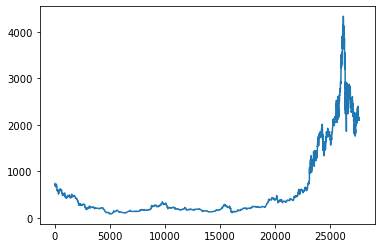

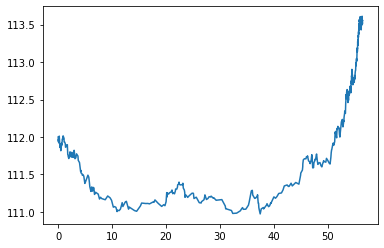

In [342]:
# ---- data loading and pre-processing ---- #

import polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

# read in time series into temporary list
temp = []
f = open('DataSets/eth.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
data = pla.bottom_up_pla(temp,1000)
pla.display_trends(data, 112)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 2
train_proportion = 0.8

# segment the data into input output pairs that we will use to train the model
def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        #print(i)
        temp = data[i:(i+seq_length*2)]
        new = []
        for x in range(0,len(temp),2):
            new.append([temp[x],temp[x+1]])
        #print(new)
        inputs.append(new)
        #print(new)
        #print("output: "+str(data[i+seq_length*2:i+seq_length*2+1]))
        #inputs.append(data[i:(i+seq_length*2)]) # the next n are the input
        #inputs.append([temp[::2],temp[1::2]])
        outputs.append(data[i+seq_length*2:i+seq_length*2+1]) # and the one after that is the output
    return Variable(torch.Tensor(np.array(inputs)).to(dev)), Variable(torch.Tensor(np.array(outputs)).to(dev))
# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)
trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [346]:
class CNN(nn.Module):
    """Convolutional Neural Networks"""
    def __init__(self, input_size, hidden_dim, output_size):
        super(CNN, self).__init__()

        self.main = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=hidden_dim, kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Flatten(),
            nn.Dropout(0.1, inplace=False),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size)
        )
        self.init_weights()
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
            m.bias.data.fill_(0.01)

    def forward(self, x):
        out = self.main(x)
        return out

net = CNN(seq_length,64,1).to(dev)
print(net)

CNN(
  (main): Sequential(
    (0): Conv1d(2, 64, kernel_size=(2,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch: 0/100, loss: 0.7315361499786377
Epoch: 10/100, loss: 0.7324626445770264
Epoch: 20/100, loss: 0.7007456421852112
Epoch: 30/100, loss: 0.6464622020721436
Epoch: 40/100, loss: 0.593488872051239
Epoch: 50/100, loss: 0.6373072266578674
Epoch: 60/100, loss: 0.6754006743431091
Epoch: 70/100, loss: 0.6895025968551636
Epoch: 80/100, loss: 0.6868774890899658
Epoch: 90/100, loss: 0.6132317185401917
Epoch: 100/100, loss: 0.6469190716743469


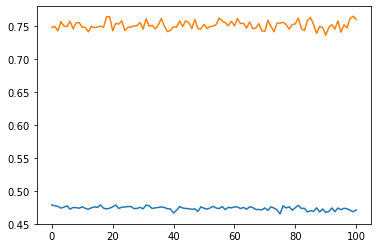

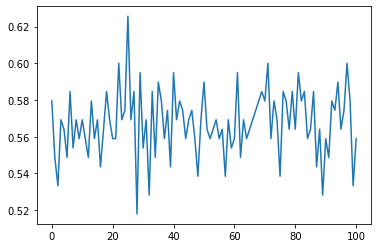

Lowest validation loss: 0.7363953930991036 at epoch 90


In [349]:
# training

epochs = 100

import torch.optim as optim
train_loss = []
validation_loss = []

epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 1000000 # the lowest validation loss
optimizer = optim.Adam(net.parameters(), lr=0.0001)
train_direction_accuracy = []
validation_direction_accuracy = []
for epoch in range(epochs+1):

    # this is the validation part, ideally we wouldn't do this every epoch, but it's easy and
    # gives good insight into when the model overfits
    for data in testset:
        features, labels = data  # split the batches up into their features and labels

        net.zero_grad()
        #print(features.unsqueeze(1).shape)
        #print(features.shape)
        output = net(features)  # get a prediction from the model
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        epoch_total_trainloss += loss.item()/len(testset)
    
    if epoch_total_trainloss < min_val_loss:
        min_val_loss = epoch_total_trainloss
        min_val_loss_epoch = epoch

    validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
    epoch_total_trainloss = 0 # reset this for the validation epoch'''
    for data in trainset:  # for each batch
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        output = net(features)  # get a prediction from the model
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)  # sum the losses of this epoch
    
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch

    # now we'll calculate the direction accuracy for the training and validation sets
    correct=0
    for data in testset:
        inputs, labels = data
        output = net(inputs)
        for i in range(len(output)):
            pred = output[i]
            actual = labels[i]
            if pred < 0 and actual < 0 or pred > 0 and actual > 0:
                correct += 1
            #print(output[0],labels[0])
    validation_direction_accuracy.append(correct/len(test))

    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")

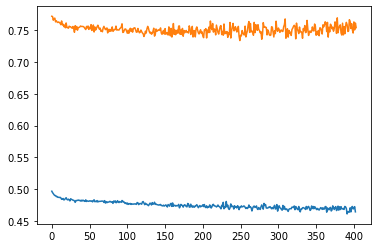

Directional Accuracy: 56.92307692307692


In [345]:
# test
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()

correct=0
for data in testset:
    inputs, labels = data
    output = net(inputs)
    for i in range(len(output)):
        pred = output[i]
        actual = labels[i]
        if pred < 0 and actual < 0 or pred > 0 and actual > 0:
            correct += 1
        #print(output[0],labels[0])
validation_direction_accuracy.append(correct/len(test))
print(f'Directional Accuracy: {correct*100/len(test)}')